#                                         Assignment

### Set up:
Importing some modules

In [1]:
from __future__ import (absolute_import, division, print_function)
import pandas as pd
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras
import json
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, MultiPolygon
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
from geoalchemy2 import Geometry, WKTElement
from sqlalchemy import *
import numpy as np
import requests
from bs4 import BeautifulSoup

import plotly.express as px
import plotly
from plotly import version
print (version)
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import json
from IPython.display import Image

<module 'plotly.version' from '/opt/jupyterhub/lib/python3.7/site-packages/plotly/version.py'>


Connecting to database

In [2]:
data_path = "."

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        HOST       = db_conn_dict['host']
        DB_USER    = db_conn_dict['user']
        DB_PW      = db_conn_dict['password']
        DEFAULT_DB = db_conn_dict['user']

        try:
            db = create_engine('postgresql://'+DB_USER+':'+DB_PW+'@'+HOST+'/'+DEFAULT_DB, echo=False)
            conn = db.connect()
            print('connected')
        except Exception as e:
            print("unable to connect to the database")
            print(e)
        return db,conn

credfilepath = os.path.join(data_path, "data2x01_db.json")

In [3]:
db,conn = pgconnect(credfilepath)

connected


### Cleaning csv files 
Removing rows with null values and making sure that area_id is unique within datasets

In [42]:
df_business = pd.read_csv("BusinessStats.csv")
print("First five rows of Business Stats dataset")
print("")
print(df_business.head(5))
print("Business stats dataset have unique area_id column:", df_business['area_id'].is_unique)
print("Business stats dataset have any null values:", df_business.isnull().values.any())
print("-------------------------------------------------------------------------------------------------")
df_neighbour = pd.read_csv("Neighbourhoods.csv")
print("First five rows of Neighbourhoods dataset")
print("")
print(df_neighbour.head(5))
print("Neighbourhoods dataset have unique area_id column:", df_neighbour['area_id'].is_unique)
print("Neighbourhoods dataset have any null values:", df_neighbour.isnull().values.any())
df_null = df_neighbour[df_neighbour.isnull().values]
print("The areas with null values are: ", df_null["area_name"].unique())
print("Row number of Neighbourhoods dataset is:", len(df_neighbour.index))
print("Number of areas with null values is:", len(df_null["area_name"].unique()))
df_neighbour = df_neighbour.dropna()
print("Neighbourhoods dataset have any null values after cleaning: ", df_neighbour.isnull().values.any())
print("Number of rows of Neighbourhoods dataset after cleaning is: ", len(df_neighbour.index))
print("-------------------------------------------------------------------------------------------------")
df_stat = pd.read_csv("StatisticalAreas.csv")
print("First five rows of Statistical Areas dataset")
print("")
print(df_stat.head(5))
df_stat = df_stat.drop_duplicates(subset = "area_id", keep = "last")
print("Statistical Areas dataset have unique area_id column:", df_stat['area_id'].is_unique)
print("Statistical Areas dataset have any null values:", df_stat.isnull().values.any())
print("-------------------------------------------------------------------------------------------------")
df_neighbour['population'] = df_neighbour['population'].str.replace(',', '').astype(int)
df_neighbour['number_of_dwellings'] = df_neighbour['number_of_dwellings'].str.replace(',', '').astype(int)

First five rows of Business Stats dataset

     area_id          area_name  number_of_businesses  \
0  101021007          Braidwood                   629   
1  101021008            Karabar                   326   
2  101021009         Queanbeyan                   724   
3  101021010  Queanbeyan - East                   580   
4  101021011  Queanbeyan Region                  1642   

   accommodation_and_food_services  retail_trade  \
0                               26            27   
1                                7            10   
2                               52            47   
3                               16            23   
4                               39            63   

   agriculture_forestry_and_fishing  health_care_and_social_assistance  \
0                               280                                 11   
1                                 8                                 11   
2                                11                                 56   
3    

### Create table in database
businessstats

In [43]:
conn.execute("DROP TABLE IF EXISTS businessstats cascade")
bussiness_schema = """CREATE TABLE IF NOT EXISTS businessstats (
                         area_id         INT,
                         area_name       VARCHAR(80),
                         number_of_businesses   INT,
                         accommodation_and_food_services   INT,
                         retail_trade   INT,
                         agriculture_forestry_and_fishing    INT,
                         health_care_and_social_assistance   INT,
                         public_administration_and_safety    INT,
                         transport_postal_and_warehousing     INT,
                         CONSTRAINT pk1_area_id PRIMARY KEY (area_id));"""
conn.execute(bussiness_schema)

statisticalareas

In [44]:
conn.execute("DROP TABLE IF EXISTS statisticalareas cascade")
statisticalArea_schema = """CREATE TABLE IF NOT EXISTS statisticalareas (
                         area_id         INT,
                         area_name       VARCHAR(80),
                         parent_area_id  INT,
                         CONSTRAINT pk2_area_id PRIMARY KEY (area_id));"""
conn.execute(statisticalArea_schema)

neighbourhoods

In [45]:
conn.execute("DROP TABLE IF EXISTS neighbourhoods cascade")
neighbourhoods_schema = """CREATE TABLE IF NOT EXISTS neighbourhoods (
                         area_id         INT,
                         area_name       VARCHAR(80),
                         land_area  FLOAT,
                         population INT,
                         number_of_dwellings INT,
                         number_of_businesses INT,
                         median_annual_household_income INT,
                         avg_monthly_rent INT,
                         CONSTRAINT pk_area_id PRIMARY KEY (area_id),
                         CONSTRAINT fk1_area_id FOREIGN KEY (area_id) REFERENCES businessstats(area_id));"""
conn.execute(neighbourhoods_schema)

### Loading BusinessStats.csv into businessstats table in database

In [46]:
table_name = "businessstats"
df_business.to_sql(table_name, con=conn, if_exists='append',index=False)

### Checking if data has been uploaded into database

In [47]:
res = pd.read_sql_query("SELECT * FROM businessstats",conn)
res

,area_id,area_name,number_of_businesses,accommodation_and_food_services,retail_trade,agriculture_forestry_and_fishing,health_care_and_social_assistance,public_administration_and_safety,transport_postal_and_warehousing
0,101021007,Braidwood,629,26,27,280,11,0,35
1,101021008,Karabar,326,7,10,8,11,0,43
2,101021009,Queanbeyan,724,52,47,11,56,3,77
3,101021010,Queanbeyan - East,580,16,23,4,12,0,57
4,101021011,Queanbeyan Region,1642,39,63,292,34,7,81
...,...,...,...,...,...,...,...,...,...
2296,901011001,Christmas Island,0,0,0,0,0,0,0
2297,901021002,Cocos (Keeling) Islands,7,3,0,0,0,0,0
2298,901031003,Jervis Bay,6,0,3,0,0,0,0
2299,901041004,Norfolk Island,0,0,0,0,0,0,0


# Loading StatisticalAreas.csv into statisticalareas table in database

In [48]:
table_name = "statisticalareas"
df_stat.to_sql(table_name, con=conn, if_exists='append',index=False)

### Checking if data has been uploaded into database

In [49]:
res = pd.read_sql_query("SELECT * FROM statisticalareas",conn)
res

,area_id,area_name,parent_area_id
0,1,New South Wales,0
1,10,Greater Sydney,1
2,11,Rest of NSW,1
3,2,Victoria,0
4,20,Greater Melbourne,2
...,...,...,...
426,106,Hunter Valley exc Newcastle,11
427,11102,Lake Macquarie - West,111
428,111,Newcastle and Lake Macquarie,11
429,11402,Southern Highlands,114


### Loading Neighbourhoods.csv into neighbourhoods table in database

In [50]:
table_name = "neighbourhoods"
df_neighbour.to_sql(table_name, con=conn, if_exists='append',index=False)

### Checking if data has been uploaded into database

In [51]:
res = pd.read_sql_query("SELECT * FROM neighbourhoods",conn)
res

,area_id,area_name,land_area,population,number_of_dwellings,number_of_businesses,median_annual_household_income,avg_monthly_rent
0,102011028,Avoca Beach - Copacabana,643.8000,7590,2325,738,46996,1906
1,102011029,Box Head - MacMasters Beach,3208.6000,10986,3847,907,42621,1682
2,102011030,Calga - Kulnura,76795.1000,4841,1575,1102,42105,1182
3,102011031,Erina - Green Point,3379.3000,14237,4450,1666,43481,1595
4,102011032,Gosford - Springfield,1691.2000,19385,6373,2126,45972,1382
...,...,...,...,...,...,...,...,...
304,106011109,Cessnock Region,1570.4341,7931,3281,673,73164,1080
305,106011113,Singleton Region,4067.2349,4919,2055,698,87984,1000
306,111021218,Morisset - Cooranbong,330.5208,14959,6298,1154,58084,1260
307,114021285,Hill Top - Colo Vale,174.3752,6025,2249,400,81120,1512


### Loading rfsnsw_bfpl shape file as geopandas dataframe

In [34]:
data_path = "./rfs_data"

In [35]:
%matplotlib inline

In [36]:
RFSNSW = gpd.read_file( os.path.join(data_path, "RFSNSW_BFPL.shp") )
RFSNSW.head()

,CATEGORY,SHAPE_LENG,SHAPE_AREA,geometry
0,1,0.000017,5.392400e-12,POINT (149.11319 -33.05824)
1,1,0.000178,1.140005e-09,POINT (152.27536 -29.68316)
2,1,0.000890,4.950178e-08,POINT (152.14244 -29.68266)
3,1,0.000442,8.094091e-09,POINT (152.27579 -29.68259)
4,1,0.000890,4.950155e-08,POINT (151.99619 -29.68131)


In [37]:
RFSNSW.head().geom_type

0    Point
1    Point
2    Point
3    Point
4    Point
dtype: object

In [9]:
def pgexecute( conn, sqlcmd, args=None, msg='', silent=False ):
    """ utility function to execute some SQL query statement
       can take optional arguments to fill in (dictionary)
       will print out on screen the result set of the query
       error and transaction handling built-in """
    retval = False
    result_set = None

    try:
        if args is None:
            result_set = conn.execute(sqlcmd).fetchall()
        else:
            result_set = conn.execute(sqlcmd, args).fetchall()

        if silent == False: 
            print("success: " + msg)
            for record in result_set:
                print(record)
        retval = True
    except Exception as e:
        if silent == False:
            print("db read error: ")
            print(e)
    return retval
def pgquery( conn, sqlcmd, args=None, silent=False ):
    """ utility function to execute some SQL query statement
    can take optional arguments to fill in (dictionary)
    will print out on screen the result set of the query
    error and transaction handling built-in """
    retdf = pd.DataFrame()
    retval = False
    try:
        if args is None:
            retdf = pd.read_sql_query(sqlcmd,conn)
        else:
            retdf = pd.read_sql_query(sqlcmd,conn,params=args)
        if silent == False:
            print(retdf.shape)
            print(retdf.to_string())
        retval = True
    except Exception as e:
        if silent == False:
            print("db read error: ")
            print(e)
    return retval,retdf

In [10]:
# lets just make sure we have PostGIS working on our connection
postgis_check = '''
SELECT PostGIS_Version();
'''

retval,retdf = pgquery(conn,postgis_check)
retdf

(1, 1)
                         postgis_version
0  3.0 USE_GEOS=1 USE_PROJ=1 USE_STATS=1


,postgis_version
0,3.0 USE_GEOS=1 USE_PROJ=1 USE_STATS=1


### Creating table for shape file "rfsnsw_bfpl"

In [40]:
RFSNSW_schema = '''CREATE TABLE rfsnsw_bfpl (
                     category VARCHAR(10), 
                     shape_leng FLOAT, 
                     shape_area FLOAT, 
                     geom GEOMETRY(POINT,4283));''' 

conn.execute("DROP TABLE IF EXISTS rfsnsw_bfpl")
conn.execute(RFSNSW_schema)

In [41]:
def create_wkt_element(geom):
    return WKTElement(geom.wkt, srid)


In [42]:
srid = 4283
rfsnswWkCpy = RFSNSW.copy()
rfsnswWkCpy['geom'] = RFSNSW['geometry'].apply(lambda x: create_wkt_element(geom=x))
rfsnswWkCpy = rfsnswWkCpy.rename(columns=str.lower)
rfsnswWkCpy = rfsnswWkCpy.drop(columns="geometry")

### Loading rfsnsw_bfpl geopandas dataframe into database table

In [43]:
RFSNSW_table_name = "rfsnsw_bfpl"
rfsnswWkCpy.to_sql(RFSNSW_table_name, conn, if_exists='append', index=False,
                   dtype={'geom': Geometry('POINT', srid)})

### Checking results if dataset has been uploaded

In [44]:
res = pd.read_sql_query("SELECT * FROM rfsnsw_bfpl", conn)
res

,category,shape_leng,shape_area,geom
0,1,0.000017,5.392400e-12,0101000020BB100000FEA38A3F9FA362403CFC9C857487...
1,1,0.000178,1.140005e-09,0101000020BB100000938508C5CF0863409579FD58E3AE...
2,1,0.000890,4.950178e-08,0101000020BB10000049F954DE8E04634017589493C2AE...
3,1,0.000442,8.094091e-09,0101000020BB1000002DDB723DD30863408ADD2B77BEAE...
4,1,0.000890,4.950155e-08,0101000020BB100000D549D9C9E0FF624097E74D1A6AAE...
...,...,...,...,...
516628,2,0.000942,3.484545e-08,0101000020BB100000372D3588FF2F63400752AF59047A...
516629,2,0.000457,8.385178e-09,0101000020BB1000006A87ADCBFF2F634048713066EEA0...
516630,2,0.001833,1.341083e-07,0101000020BB1000002D750FCA00306340EA32EDA84C84...
516631,2,0.012603,3.187411e-06,0101000020BB1000000C032703652C63402EA7684DC27F...


### Same process as above for sa2_2016_aust shape file

In [52]:
data_path_1 = "./sa2_data"

In [53]:
sa2 = gpd.read_file( os.path.join(data_path_1, "SA2_2016_AUST.shp") )
sa2

,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,GCC_CODE16,GCC_NAME16,STE_CODE16,STE_NAME16,AREASQKM16,geometry
0,101021007,11007,Braidwood,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3418.3525,"POLYGON ((149.58423 -35.44427, 149.58444 -35.4..."
1,101021008,11008,Karabar,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,6.9825,"POLYGON ((149.21898 -35.36739, 149.21799 -35.3..."
2,101021009,11009,Queanbeyan,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,4.7634,"POLYGON ((149.21325 -35.34325, 149.21619 -35.3..."
3,101021010,11010,Queanbeyan - East,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,13.0034,"POLYGON ((149.24033 -35.34782, 149.24023 -35.3..."
4,101021011,11011,Queanbeyan Region,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3054.4099,"POLYGON ((149.23580 -35.38738, 149.23771 -35.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2305,901021002,91002,Cocos (Keeling) Islands,90102,Cocos (Keeling) Islands,901,Other Territories,9OTER,Other Territories,9,Other Territories,13.7163,"MULTIPOLYGON (((96.83047 -12.17636, 96.83045 -..."
2306,901031003,91003,Jervis Bay,90103,Jervis Bay,901,Other Territories,9OTER,Other Territories,9,Other Territories,67.8134,"MULTIPOLYGON (((150.69566 -35.18297, 150.69555..."
2307,901041004,91004,Norfolk Island,90104,Norfolk Island,901,Other Territories,9OTER,Other Territories,9,Other Territories,38.6509,"MULTIPOLYGON (((167.99472 -29.04534, 167.99432..."
2308,997979799,99799,Migratory - Offshore - Shipping (OT),99797,Migratory - Offshore - Shipping (OT),997,Migratory - Offshore - Shipping (OT),99799,Migratory - Offshore - Shipping (OT),9,Other Territories,0.0000,None


In [54]:
sa2 = sa2.dropna()

In [55]:
sa2

,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,GCC_CODE16,GCC_NAME16,STE_CODE16,STE_NAME16,AREASQKM16,geometry
0,101021007,11007,Braidwood,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3418.3525,"POLYGON ((149.58423 -35.44427, 149.58444 -35.4..."
1,101021008,11008,Karabar,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,6.9825,"POLYGON ((149.21898 -35.36739, 149.21799 -35.3..."
2,101021009,11009,Queanbeyan,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,4.7634,"POLYGON ((149.21325 -35.34325, 149.21619 -35.3..."
3,101021010,11010,Queanbeyan - East,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,13.0034,"POLYGON ((149.24033 -35.34782, 149.24023 -35.3..."
4,101021011,11011,Queanbeyan Region,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3054.4099,"POLYGON ((149.23580 -35.38738, 149.23771 -35.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2301,801111141,81141,Namadgi,80111,Urriarra - Namadgi,801,Australian Capital Territory,8ACTE,Australian Capital Territory,8,Australian Capital Territory,1202.8930,"POLYGON ((148.80406 -35.37620, 148.80416 -35.3..."
2304,901011001,91001,Christmas Island,90101,Christmas Island,901,Other Territories,9OTER,Other Territories,9,Other Territories,136.1356,"POLYGON ((105.67392 -10.41567, 105.67398 -10.4..."
2305,901021002,91002,Cocos (Keeling) Islands,90102,Cocos (Keeling) Islands,901,Other Territories,9OTER,Other Territories,9,Other Territories,13.7163,"MULTIPOLYGON (((96.83047 -12.17636, 96.83045 -..."
2306,901031003,91003,Jervis Bay,90103,Jervis Bay,901,Other Territories,9OTER,Other Territories,9,Other Territories,67.8134,"MULTIPOLYGON (((150.69566 -35.18297, 150.69555..."


In [56]:
sa2.geom_type

0            Polygon
1            Polygon
2            Polygon
3            Polygon
4            Polygon
            ...     
2301         Polygon
2304         Polygon
2305    MultiPolygon
2306    MultiPolygon
2307    MultiPolygon
Length: 2292, dtype: object

In [57]:
sa2_schema = '''CREATE TABLE sa2_2016_aust (
                     sa2_main16 INT ,
                     sa2_5dig16 INT, 
                     sa2_name16 VARCHAR, 
                     sa3_code16 INT,
                     sa3_name16 VARCHAR,
                     sa4_code16 INT,
                     sa4_name16 VARCHAR,
                     gcc_code16 VARCHAR,
                     gcc_name16 VARCHAR,
                     ste_code16 INT,
                     ste_name16 VARCHAR,
                     areasqkm16 FLOAT,
                     geom GEOMETRY(MULTIPOLYGON,4283),
                     CONSTRAINT fk2_area_id FOREIGN KEY (sa2_main16) REFERENCES businessstats(area_id));''' 

conn.execute("DROP TABLE IF EXISTS sa2_2016_aust")
conn.execute(sa2_schema)

### To make sure geom column has same geometry type converting all geom_type into "MULTYPOLYGON"

In [58]:
def create_wkt_element_sa2(geom,srid):
    if (geom.geom_type == 'Polygon'):
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

In [59]:
srid = 4283

# since we are altering data again, we should create another copy
sa2WkCpy = sa2.copy()
sa2WkCpy['geom'] = sa2['geometry'].apply(lambda x: create_wkt_element_sa2(geom=x,srid=srid))
#delete the old column before insert
sa2WkCpy = sa2WkCpy.drop(columns="geometry")
sa2WkCpy = sa2WkCpy.rename(columns=str.lower)
sa2WkCpy

,sa2_main16,sa2_5dig16,sa2_name16,sa3_code16,sa3_name16,sa4_code16,sa4_name16,gcc_code16,gcc_name16,ste_code16,ste_name16,areasqkm16,geom
0,101021007,11007,Braidwood,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3418.3525,MULTIPOLYGON (((149.5842329970001 -35.44426999...
1,101021008,11008,Karabar,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,6.9825,MULTIPOLYGON (((149.2189819130001 -35.36739402...
2,101021009,11009,Queanbeyan,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,4.7634,MULTIPOLYGON (((149.2132479820001 -35.34324799...
3,101021010,11010,Queanbeyan - East,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,13.0034,MULTIPOLYGON (((149.240332114 -35.347822616999...
4,101021011,11011,Queanbeyan Region,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3054.4099,MULTIPOLYGON (((149.235800967 -35.387375302999...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2301,801111141,81141,Namadgi,80111,Urriarra - Namadgi,801,Australian Capital Territory,8ACTE,Australian Capital Territory,8,Australian Capital Territory,1202.8930,MULTIPOLYGON (((148.804064002 -35.376204003999...
2304,901011001,91001,Christmas Island,90101,Christmas Island,901,Other Territories,9OTER,Other Territories,9,Other Territories,136.1356,MULTIPOLYGON (((105.6739190100001 -10.41567300...
2305,901021002,91002,Cocos (Keeling) Islands,90102,Cocos (Keeling) Islands,901,Other Territories,9OTER,Other Territories,9,Other Territories,13.7163,MULTIPOLYGON (((96.83046599400006 -12.17635995...
2306,901031003,91003,Jervis Bay,90103,Jervis Bay,901,Other Territories,9OTER,Other Territories,9,Other Territories,67.8134,MULTIPOLYGON (((150.6956629970001 -35.18296700...


In [60]:
# Use 'dtype' to specify column's type
# For the geom column, we will use GeoAlchemy's type 'Geometry'
sa2_table_name = "sa2_2016_aust"
sa2WkCpy.to_sql(sa2_table_name, conn, if_exists='append', index=False, 
                         dtype={'geom': Geometry('MULTIPOLYGON', srid)})

In [61]:
res = pd.read_sql_query("SELECT * FROM sa2_2016_aust", conn)
res

,sa2_main16,sa2_5dig16,sa2_name16,sa3_code16,sa3_name16,sa4_code16,sa4_name16,gcc_code16,gcc_name16,ste_code16,ste_name16,areasqkm16,geom
0,101021007,11007,Braidwood,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3418.3525,0106000020BB100000010000000103000000010000005F...
1,101021008,11008,Karabar,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,6.9825,0106000020BB100000010000000103000000010000002C...
2,101031016,11016,Jindabyne - Berridale,10103,Snowy Mountains,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3939.5484,0106000020BB100000010000000103000000010000005F...
3,101041017,11017,Batemans Bay,10104,South Coast,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,63.7074,0106000020BB1000000100000001030000000100000036...
4,101041018,11018,Batemans Bay - South,10104,South Coast,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,30.5948,0106000020BB100000070000000103000000010000001C...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2287,801111141,81141,Namadgi,80111,Urriarra - Namadgi,801,Australian Capital Territory,8ACTE,Australian Capital Territory,8,Australian Capital Territory,1202.8930,0106000020BB100000010000000103000000010000000C...
2288,901011001,91001,Christmas Island,90101,Christmas Island,901,Other Territories,9OTER,Other Territories,9,Other Territories,136.1356,0106000020BB1000000100000001030000000100000094...
2289,901021002,91002,Cocos (Keeling) Islands,90102,Cocos (Keeling) Islands,901,Other Territories,9OTER,Other Territories,9,Other Territories,13.7163,0106000020BB100000380000000103000000010000000E...
2290,901031003,91003,Jervis Bay,90103,Jervis Bay,901,Other Territories,9OTER,Other Territories,9,Other Territories,67.8134,0106000020BB1000000300000001030000000100000017...


## Web Scrapping - Additional Dataset

In [57]:
webpage_source = requests.get("http://www.rfs.nsw.gov.au/about-us/fire-control-centres").text

In [58]:
page_content = BeautifulSoup(webpage_source, 'html5lib')
service_detail  = page_content.find(id="nest-fire-control-centres")

In [59]:
names_tag = service_detail.find_all("name")
address_tag = service_detail.find_all("street-address")

In [60]:
names = []
two_names = []
for name in names_tag:
    if("," in name.text):
        two_names = name.text.split(",")
        names.append(two_names[0]+")")
        names.append(name.text.split("(")[0] + two_names[1])
    elif ("Cootamundra-Gundagai Local Government Area (Riverina Highlands/South West Slopes office" in name.text):
        two_names = name.text.split("/")
        names.append(two_names[0]+")")
        names.append(name.text.split("(")[0] + two_names[1])
    else:
        names.append(name.text)

In [61]:
street_addresses = []
for add in address_tag:
    if (add.find(text = True, recursive = False)==" "):
        continue
    else:
        street_addresses.append(add.find(text = True, recursive = False))
print(street_addresses)

[' 25 Airport Drive, Albury 2640', ' 10 Mann St, Armidale 2350', ' 70-90 Station St, Mullumbimby 2482', ' 58-60 Mitchell Ave, Dareton 2717', ' 27 Hampden Park Road, Kelso 2795', ' Maher Street, Bega 2550', ' 1 Aviation Drive, Coffs Harbour 2450', ' 311 Redlands Road, Corowa 2646', ' 8-12 Jeanette Street, Regentville 2745', ' 221 Neeld Street, West Wyalong 2671', ' 1385 Forest Road, Orange 2800', ' Cnr Bathurst Rd and Valley Road, Katoomba 2780', ' Lot 1001 Lawlor Street, Nyngan 2825', ' North Bourke Airport, Airport Road, Bourke 2840', ' 9-11 Young Street, Brewarrina 2839', ' 70-90 Station St, Mullumbimby 2482', ' 1385 Forest Road, Orange 2800', ' Cnr Alderney St and Townson Ave, Minto 2566', ' Cnr Alderney St and Townson Ave, Minto 2566', ' 200 Wakaden Street, Griffith 2680', ' Cnr Reid and Martin Streets, Wilcannia 2836', ' 105 Arizona Road Charmhaven NSW  2263', ' 110 Mt Vincent Road, East Maitland 2323', ' 15 Coldstream St, Ulmarra 2462', ' Railway Parade North, Cobar 2835', ' 1 Av

In [62]:
print(len(names), len(street_addresses))

111 111


### Some cleaning

In [63]:
i = 0
for i in range(len(street_addresses)):
    if street_addresses[i] == " Lot 1001 Lawlor Street, Nyngan 2825":
        street_addresses[i] = " Lawlor Street, Nyngan 2825"
    elif street_addresses[i] == " North Bourke Airport, Airport Road, Bourke 2840":
        street_addresses[i] = " North Bourke, New South Wales 2840"
    elif street_addresses[i] == " Cnr Alderney St and Townson Ave, Minto 2566":
        street_addresses[i] = " Townson Ave, Minto NSW 2566"
    elif street_addresses[i] == " Cnr Reid and Martin Streets, Wilcannia 2836":
        street_addresses[i] = " Martin Street, Wilcannia NSW 2836"
    elif street_addresses[i] == " South West Slopes Office, Trinity Centre East St, Harden 2587":
        street_addresses[i] = " East St, Harden NSW 2587"
    elif street_addresses[i] == " Riverina Highlands Office, 76 Capper Street, Tumut 2720":
        street_addresses[i] = " 76 Capper St, Tumut NSW 2720"
    elif street_addresses[i] == " Southern Border Office, 311 Redlands Road, Corowa 2646":
        street_addresses[i] = " 311 Redlands Rd, Corowa NSW 2646"
    elif street_addresses[i] == " Riverina Office, 208 Fernleigh Road, Wagga Wagga 2650":
        street_addresses[i] = " 208 Fernleigh Road, Wagga Wagga 2650"
    elif street_addresses[i] == " Cnr Derri and Warrie Street, Gilgandra 2827":
        street_addresses[i] = " Warrie Street, Gilgandra 2827"
    elif street_addresses[i] == " Bennet Road, Gunnedah 2380":
        street_addresses[i] = " Bennett Rd, Gunnedah NSW 2380"
    elif street_addresses[i] == " Trinity Centre East St, Harden 2587":
        street_addresses[i] = " East St, Harden NSW 2587"
    elif street_addresses[i] == " 52 Burtonshaw Road, Inverell 2360":
        street_addresses[i] = " 52 Burtenshaw Rd, Inverell NSW 2360"
    elif street_addresses[i] == " Cnr Alderney St and Townson Ave, Minto 2566":
        street_addresses[i] = " Alderney St, Minto NSW 2566"
    elif street_addresses[i] == " Great Lakes Office, 5a South Street, Tuncurry 2428":
        street_addresses[i] = " 5A South St, Tuncurry NSW 2428"
    elif street_addresses[i] == " Mid-Coast Office, 28 Muldoon Street, Taree 2430":
        street_addresses[i] = " 28 Muldoon Street, Taree 2430"
    elif street_addresses[i] == " Works Depot, Tycannah Street, Moree 2400":
        street_addresses[i] = " Tycannah St, Moree NSW 2400"
    elif street_addresses[i] == " Thompson Dr Off Kamber Rd, Terrey Hills 2084":
        street_addresses[i] = " Kamber Rd, Terrey Hills NSW 2084"
    elif street_addresses[i] == " Geebung Street, Cooma 2630":
        street_addresses[i] = " Geebung St NSW 2630"
    elif street_addresses[i] == " Cnr Marquet and Bettington Streets, Merriwa 2329":
        street_addresses[i] = " Bettington Street, Merriwa 2329"
    elif street_addresses[i] == " Lot 1 Macintosh Road, Crookwell 2583":
        street_addresses[i] = " 1 McIntosh Rd, Crookwell NSW 2583"
    elif street_addresses[i] == " Cnr Priestley and Etheridge Sts, Mittagong 2575":
        street_addresses[i] = " Etheridge St, Mittagong NSW 2575"

In [64]:
service_dict = {"name":names, "address":street_addresses}

In [65]:
service_df = pd.DataFrame(service_dict)
service_df

,name,address
0,Albury Local Government Area (Southern Border ...,"25 Airport Drive, Albury 2640"
1,Armidale Regional Local Government Area (New E...,"10 Mann St, Armidale 2350"
2,Ballina Local Government Area (Far North Coast...,"70-90 Station St, Mullumbimby 2482"
3,Balranald Local Government Area (Lower Western...,"58-60 Mitchell Ave, Dareton 2717"
4,Bathurst Regional Local Government Area (Chifl...,"27 Hampden Park Road, Kelso 2795"
...,...,...
106,Wentworth Local Government Area (Lower Western...,"58-60 Mitchell Ave, Dareton 2717"
107,Wingecarribee Local Government Area (Southern ...,"Etheridge St, Mittagong NSW 2575"
108,Wollondilly Local Government Area (Southern Hi...,"65 Bridge Street, Picton 2571"
109,Wollongong Local Government Area (Illawarra of...,"37 Airport Road, Albion Park Rail 2527"


### Get geom_type POINT using geocode

In [67]:
geo = gpd.tools.geocode(service_df['address'], provider='nominatim', user_agent='autogis_xx', timeout=4) 

In [70]:
join = geo.join(service_df, how = 'right', lsuffix = '_right', rsuffix = '_left')
join = join.drop(columns = ["address_right"])
join

,geometry,name,address_left
0,POINT (146.95567 -36.07176),Albury Local Government Area (Southern Border ...,"25 Airport Drive, Albury 2640"
1,POINT (151.68358 -30.52684),Armidale Regional Local Government Area (New E...,"10 Mann St, Armidale 2350"
2,POINT (153.50234 -28.55337),Ballina Local Government Area (Far North Coast...,"70-90 Station St, Mullumbimby 2482"
3,POINT (142.04350 -34.09205),Balranald Local Government Area (Lower Western...,"58-60 Mitchell Ave, Dareton 2717"
4,POINT (149.61967 -33.42498),Bathurst Regional Local Government Area (Chifl...,"27 Hampden Park Road, Kelso 2795"
...,...,...,...
106,POINT (142.04350 -34.09205),Wentworth Local Government Area (Lower Western...,"58-60 Mitchell Ave, Dareton 2717"
107,POINT (150.43600 -34.45031),Wingecarribee Local Government Area (Southern ...,"Etheridge St, Mittagong NSW 2575"
108,POINT (150.60114 -34.19288),Wollondilly Local Government Area (Southern Hi...,"65 Bridge Street, Picton 2571"
109,POINT (150.79092 -34.55932),Wollongong Local Government Area (Illawarra of...,"37 Airport Road, Albion Park Rail 2527"


In [71]:
join = join.rename(columns = {"address_left":"address"})
join

,geometry,name,address
0,POINT (146.95567 -36.07176),Albury Local Government Area (Southern Border ...,"25 Airport Drive, Albury 2640"
1,POINT (151.68358 -30.52684),Armidale Regional Local Government Area (New E...,"10 Mann St, Armidale 2350"
2,POINT (153.50234 -28.55337),Ballina Local Government Area (Far North Coast...,"70-90 Station St, Mullumbimby 2482"
3,POINT (142.04350 -34.09205),Balranald Local Government Area (Lower Western...,"58-60 Mitchell Ave, Dareton 2717"
4,POINT (149.61967 -33.42498),Bathurst Regional Local Government Area (Chifl...,"27 Hampden Park Road, Kelso 2795"
...,...,...,...
106,POINT (142.04350 -34.09205),Wentworth Local Government Area (Lower Western...,"58-60 Mitchell Ave, Dareton 2717"
107,POINT (150.43600 -34.45031),Wingecarribee Local Government Area (Southern ...,"Etheridge St, Mittagong NSW 2575"
108,POINT (150.60114 -34.19288),Wollondilly Local Government Area (Southern Hi...,"65 Bridge Street, Picton 2571"
109,POINT (150.79092 -34.55932),Wollongong Local Government Area (Illawarra of...,"37 Airport Road, Albion Park Rail 2527"


### Uploading data into database 
Name of the table is "fire_service"

In [72]:
fireservice_schema = '''CREATE TABLE fire_service (
                         index INT PRIMARY KEY,
                         geom GEOMETRY(POINT,4283),
                         name VARCHAR,
                         address VARCHAR);''' 

conn.execute("DROP TABLE IF EXISTS fire_service")
conn.execute(fireservice_schema)

In [73]:
def create_wkt_element(geom):
    return WKTElement(geom.wkt, srid)

In [74]:
srid = 4283
fireserviceCopy = join.copy()
fireserviceCopy['geom'] = join['geometry'].apply(lambda x: create_wkt_element(geom=x))
fireserviceCopy = fireserviceCopy.drop(columns="geometry")

In [75]:
fire_service_table = "fire_service"
fireserviceCopy.to_sql(fire_service_table, conn, if_exists='append', index=True,
                   dtype={'geom': Geometry('POINT', srid)})

In [76]:
res = pd.read_sql_query("SELECT * FROM fire_service", conn)
res

,index,geom,name,address
0,0,0101000020BB10000019FB37D4945E62404796276B2F09...,Albury Local Government Area (Southern Border ...,"25 Airport Drive, Albury 2640"
1,1,0101000020BB1000007503C1DBDFF562407CD866BEDE86...,Armidale Regional Local Government Area (New E...,"10 Mann St, Armidale 2350"
2,2,0101000020BB10000047600729133063400932A770A98D...,Ballina Local Government Area (Far North Coast...,"70-90 Station St, Mullumbimby 2482"
3,3,0101000020BB100000A387EB6264C16140D53F8864C80B...,Balranald Local Government Area (Lower Western...,"58-60 Mitchell Ave, Dareton 2717"
4,4,0101000020BB100000FF092E56D4B3624067AE1DD665B6...,Bathurst Regional Local Government Area (Chifl...,"27 Hampden Park Road, Kelso 2795"
...,...,...,...,...
106,106,0101000020BB100000A387EB6264C16140D53F8864C80B...,Wentworth Local Government Area (Lower Western...,"58-60 Mitchell Ave, Dareton 2717"
107,107,0101000020BB100000A73E90BCF3CD624047904AB1A339...,Wingecarribee Local Government Area (Southern ...,"Etheridge St, Mittagong NSW 2575"
108,108,0101000020BB100000404CC2853CD36240A69BC420B018...,Wollondilly Local Government Area (Southern Hi...,"65 Bridge Street, Picton 2571"
109,109,0101000020BB100000EEDAFC3C4FD962401DDDADD19747...,Wollongong Local Government Area (Illawarra of...,"37 Airport Road, Albion Park Rail 2527"


In [77]:
conn.execute("""ALTER TABLE fire_service
RENAME COLUMN index TO gid;""")

In [78]:
res = pd.read_sql_query("SELECT * FROM fire_service", conn)
res

,gid,geom,name,address
0,0,0101000020BB10000019FB37D4945E62404796276B2F09...,Albury Local Government Area (Southern Border ...,"25 Airport Drive, Albury 2640"
1,1,0101000020BB1000007503C1DBDFF562407CD866BEDE86...,Armidale Regional Local Government Area (New E...,"10 Mann St, Armidale 2350"
2,2,0101000020BB10000047600729133063400932A770A98D...,Ballina Local Government Area (Far North Coast...,"70-90 Station St, Mullumbimby 2482"
3,3,0101000020BB100000A387EB6264C16140D53F8864C80B...,Balranald Local Government Area (Lower Western...,"58-60 Mitchell Ave, Dareton 2717"
4,4,0101000020BB100000FF092E56D4B3624067AE1DD665B6...,Bathurst Regional Local Government Area (Chifl...,"27 Hampden Park Road, Kelso 2795"
...,...,...,...,...
106,106,0101000020BB100000A387EB6264C16140D53F8864C80B...,Wentworth Local Government Area (Lower Western...,"58-60 Mitchell Ave, Dareton 2717"
107,107,0101000020BB100000A73E90BCF3CD624047904AB1A339...,Wingecarribee Local Government Area (Southern ...,"Etheridge St, Mittagong NSW 2575"
108,108,0101000020BB100000404CC2853CD36240A69BC420B018...,Wollondilly Local Government Area (Southern Hi...,"65 Bridge Street, Picton 2571"
109,109,0101000020BB100000EEDAFC3C4FD962401DDDADD19747...,Wollongong Local Government Area (Illawarra of...,"37 Airport Road, Albion Park Rail 2527"


## At the end we are checking if all tables are uploaded into database

In [62]:
print(db.table_names())

['organisations', 'spatial_ref_sys', 'measurementswk4', 'MeasurementsWk4', 'rfsnsw_bfpl', 'joined_neighbourhood', 'world', 'fire_service', 'rfsnsw_bfpl_small', 'joined_service_spatial', 'joined_spatial', 'final_bfpl', 'final_bfpl1', 'final_dataset', 'density', 'risk_score', 'statisticalareas', 'businessstats', 'neighbourhoods', 'sa2_2016_aust']


## Joining three csv datasets using 1 common column area_id

In [4]:
res = pd.read_sql_query("SELECT * FROM businessstats JOIN statisticalareas USING (area_id , area_name) JOIN neighbourhoods USING(area_id , area_name);",conn)
res1 = res.loc[:, ~res.columns.duplicated()]
res1


,area_id,area_name,number_of_businesses,accommodation_and_food_services,retail_trade,agriculture_forestry_and_fishing,health_care_and_social_assistance,public_administration_and_safety,transport_postal_and_warehousing,parent_area_id,land_area,population,number_of_dwellings,median_annual_household_income,avg_monthly_rent
0,101051540,Goulburn Region,1891,38,52,1041,33,3,81,10105,9035.1221,12670,6817,62712.0,800.0
1,102011028,Avoca Beach - Copacabana,724,33,35,4,60,0,19,10201,643.8000,7590,2325,46996.0,1906.0
2,102011029,Box Head - MacMasters Beach,934,23,45,13,43,3,28,10201,3208.6000,10986,3847,42621.0,1682.0
3,102011030,Calga - Kulnura,1134,14,43,231,12,0,55,10201,76795.1000,4841,1575,42105.0,1182.0
4,102011031,Erina - Green Point,1712,68,145,19,179,12,43,10201,3379.3000,14237,4450,43481.0,1595.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,128021536,Oyster Bay - Como - Jannali,1655,52,84,15,92,11,120,12802,890.5000,22084,5931,55391.0,1947.0
305,128021538,Sutherland - Kirrawee,2136,73,113,6,127,17,122,12802,775.5000,21760,6924,53378.0,1809.0
306,128021607,Engadine,1106,37,69,3,82,9,51,12802,895.4000,17424,5219,52667.0,1955.0
307,128021608,Loftus - Yarrawarrah,452,9,20,3,25,5,31,12802,384.4000,7426,2177,51243.0,2163.0


### Performing some cleaning:
Combining two columns "health_care_and_social_assistance" and "public_administration_and_safety" into 1 column called "assistive_service" for further calculation of assistive_service_density.

In [5]:
res1["assistive_service"] = res1["health_care_and_social_assistance"] + res1["public_administration_and_safety"]
res1

,area_id,area_name,number_of_businesses,accommodation_and_food_services,retail_trade,agriculture_forestry_and_fishing,health_care_and_social_assistance,public_administration_and_safety,transport_postal_and_warehousing,parent_area_id,land_area,population,number_of_dwellings,median_annual_household_income,avg_monthly_rent,assistive_service
0,101051540,Goulburn Region,1891,38,52,1041,33,3,81,10105,9035.1221,12670,6817,62712.0,800.0,36
1,102011028,Avoca Beach - Copacabana,724,33,35,4,60,0,19,10201,643.8000,7590,2325,46996.0,1906.0,60
2,102011029,Box Head - MacMasters Beach,934,23,45,13,43,3,28,10201,3208.6000,10986,3847,42621.0,1682.0,46
3,102011030,Calga - Kulnura,1134,14,43,231,12,0,55,10201,76795.1000,4841,1575,42105.0,1182.0,12
4,102011031,Erina - Green Point,1712,68,145,19,179,12,43,10201,3379.3000,14237,4450,43481.0,1595.0,191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,128021536,Oyster Bay - Como - Jannali,1655,52,84,15,92,11,120,12802,890.5000,22084,5931,55391.0,1947.0,103
305,128021538,Sutherland - Kirrawee,2136,73,113,6,127,17,122,12802,775.5000,21760,6924,53378.0,1809.0,144
306,128021607,Engadine,1106,37,69,3,82,9,51,12802,895.4000,17424,5219,52667.0,1955.0,91
307,128021608,Loftus - Yarrawarrah,452,9,20,3,25,5,31,12802,384.4000,7426,2177,51243.0,2163.0,30


### Creating table in database for 3 joined csv datasets

In [6]:
conn.execute("DROP TABLE IF EXISTS joined_neighbourhood")

joined_neighbourhoods_schema = """CREATE TABLE IF NOT EXISTS joined_neighbourhood (
                         area_id         INT PRIMARY KEY,
                         area_name       VARCHAR(80),
                         number_of_businesses INT,
                         accommodation_and_food_services INT,
                         retail_trade INT,
                         agriculture_forestry_and_fishing INT,
                         health_care_and_social_assistance INT,
                         public_administration_and_safety INT,
                         transport_postal_and_warehousing INT, 
                         parent_area_id INT, 
                         land_area  FLOAT,
                         population INT,
                         num_dwellings INT,
                         median_annual_household_income INT,
                         avg_month_rent INT,
                         assistive_service INT);"""
conn.execute(joined_neighbourhoods_schema)

In [7]:
table_name = "joined_neighbourhood"
res1.to_sql(table_name, con=conn, if_exists='replace',index=False)

In [8]:
res2 = pd.read_sql_query("SELECT * FROM joined_neighbourhood",conn)
res2

,area_id,area_name,number_of_businesses,accommodation_and_food_services,retail_trade,agriculture_forestry_and_fishing,health_care_and_social_assistance,public_administration_and_safety,transport_postal_and_warehousing,parent_area_id,land_area,population,number_of_dwellings,median_annual_household_income,avg_monthly_rent,assistive_service
0,101051540,Goulburn Region,1891,38,52,1041,33,3,81,10105,9035.1221,12670,6817,62712.0,800.0,36
1,102011028,Avoca Beach - Copacabana,724,33,35,4,60,0,19,10201,643.8000,7590,2325,46996.0,1906.0,60
2,102011029,Box Head - MacMasters Beach,934,23,45,13,43,3,28,10201,3208.6000,10986,3847,42621.0,1682.0,46
3,102011030,Calga - Kulnura,1134,14,43,231,12,0,55,10201,76795.1000,4841,1575,42105.0,1182.0,12
4,102011031,Erina - Green Point,1712,68,145,19,179,12,43,10201,3379.3000,14237,4450,43481.0,1595.0,191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,128021536,Oyster Bay - Como - Jannali,1655,52,84,15,92,11,120,12802,890.5000,22084,5931,55391.0,1947.0,103
305,128021538,Sutherland - Kirrawee,2136,73,113,6,127,17,122,12802,775.5000,21760,6924,53378.0,1809.0,144
306,128021607,Engadine,1106,37,69,3,82,9,51,12802,895.4000,17424,5219,52667.0,1955.0,91
307,128021608,Loftus - Yarrawarrah,452,9,20,3,25,5,31,12802,384.4000,7426,2177,51243.0,2163.0,30


### Loading rfsnsw_bfpl_small shape file into database it is exactly same process as loading rfsnsw_bfpl

In [66]:
data_path = "./rfs_small_data"

In [68]:
RFSNSW = gpd.read_file( os.path.join(data_path, "RFSNSW_BFPL_small.shp") )
RFSNSW.head()

,CATEGORY,SHAPE_LENG,SHAPE_AREA,geometry
0,1,0.000890,4.949777e-08,POINT (149.83171 -34.29903)
1,1,0.008990,1.417500e-06,POINT (149.85673 -34.29558)
2,1,0.011250,1.775249e-06,POINT (149.84108 -34.29475)
3,1,0.001096,3.735098e-08,POINT (149.82560 -34.28852)
4,1,0.027890,6.131269e-06,POINT (149.74439 -34.26993)


In [69]:
RFSNSW.head().geom_type

0    Point
1    Point
2    Point
3    Point
4    Point
dtype: object

In [72]:
RFSNSW_schema = '''CREATE TABLE rfsnsw_bfpl_small (
                     category VARCHAR(10), 
                     shape_leng FLOAT, 
                     shape_area FLOAT, 
                     geom GEOMETRY(POINT,4283));''' 

conn.execute("DROP TABLE IF EXISTS rfsnsw_bfpl_small")
conn.execute(RFSNSW_schema)

In [73]:
def create_wkt_element(geom):
    return WKTElement(geom.wkt, srid)

In [74]:
srid = 4283

# since we are altering data again, we should create another copy
rfsnswWkCpy = RFSNSW.copy()
rfsnswWkCpy['geom'] = RFSNSW['geometry'].apply(lambda x: create_wkt_element(geom=x))
rfsnswWkCpy = rfsnswWkCpy.rename(columns=str.lower)
#delete the old column before insert
rfsnswWkCpy = rfsnswWkCpy.drop(columns="geometry")

In [75]:
# Use 'dtype' to specify column's type
# For the geom column, we will use GeoAlchemy's type 'Geometry'
RFSNSW_table_name = "rfsnsw_bfpl_small"
rfsnswWkCpy.to_sql(RFSNSW_table_name, conn, if_exists='append', index=False,
                   dtype={'geom': Geometry('POINT', srid)})

In [13]:
res = pd.read_sql_query("SELECT * FROM rfsnsw_bfpl_small", conn)
res

,category,shape_leng,shape_area,geom,buffer_geom,buffer_geom_area,total_buffer_area
0,1,0.00809,1.212746e-06,0101000020BB1000006B7822D2E6E6624086D0665A5347...,0103000020BB10000001000000210000009EAB55051AEA...,0.031214,0.031216
1,1,0.00405,5.062500e-07,0101000020BB100000504182D2D0E362400A7CD2CFD446...,0103000020BB10000001000000210000008374B50504E7...,0.031214,0.031215
2,1,0.00180,1.530031e-07,0101000020BB100000BC41720AF5E06240F5D01B33BC46...,0103000020BB1000000100000021000000EF74A53D28E4...,0.031214,0.031215
3,1,0.00089,4.949979e-08,0101000020BB100000EFEBCB6262E16240031F0F52B746...,0103000020BB1000000100000021000000221FFF9595E4...,0.031214,0.031215
4,1,0.00540,1.014754e-06,0101000020BB1000002B0AAD9EE8DF6240A394DC20A446...,0103000020BB10000001000000210000005E3DE0D11BE3...,0.031214,0.031215
...,...,...,...,...,...,...,...
45309,1,0.00089,4.950178e-08,0101000020BB10000043A606B133E76240C5FBB5180348...,0103000020BB100000010000002100000076D939E466EA...,0.031214,0.031215
45310,1,0.00089,4.949799e-08,0101000020BB100000FDF202ECA3E66240C43419DCD647...,0103000020BB10000001000000210000003026361FD7E9...,0.031214,0.031215
45311,1,0.00089,4.949997e-08,0101000020BB100000570B48A297E0624024DA18E56047...,0103000020BB10000001000000210000008A3E7BD5CAE3...,0.031214,0.031215
45312,1,0.00766,1.111498e-06,0101000020BB100000D6E10E92E8E062401A7A3A6E8347...,0103000020BB1000000100000021000000091542C51BE4...,0.031214,0.031216


### Create spatial index for geom column in sa2_2016_aust table and geom column in rfsnsw_bfpl_small table
This will ensure faster spatial join between these tables on column geom

In [14]:
index_command = "CREATE INDEX sa2_index ON sa2_2016_aust USING GIST (geom)"
conn.execute("DROP INDEX IF ExISTS sa2_index ")
conn.execute(index_command)

In [12]:
index_command1 = "CREATE INDEX rfsnsw_index ON rfsnsw_bfpl_small USING GIST (geom)"
conn.execute("DROP INDEX IF ExISTS rfsnsw_index ")
conn.execute(index_command1)

### Performing spatial join between sa2_2016_aust and rfsnsw_bfpl_small on their geom columns. 
RFS.geom is a POINT type and SA2.geom is MULTIPOLYGON type. We joined these datasets using the fact that some point in rfsnsw_bfpl_small datasets is contained inside of multipolygon in sa2_2016_aust dataset.

In [20]:
spatial_join_schema = """DROP TABLE IF EXISTS joined_spatial;
                         CREATE TABLE IF NOT EXISTS joined_spatial AS(
                         SELECT sa2_main16, sa2_name16, sa3_name16, sa3_code16, areasqkm16, category, shape_leng, shape_area, SA2.geom
                         FROM sa2_2016_aust SA2 JOIN rfsnsw_bfpl_small RFS ON ST_Intersects(SA2.geom,RFS.geom)
                         );
"""
conn.execute(spatial_join_schema)

### Checking created table
(geom column takes very long to run thus was not included)

In [21]:
res4 = pd.read_sql_query("SELECT sa2_main16, sa2_name16, sa3_name16, sa3_code16, areasqkm16, category, shape_leng, shape_area FROM joined_spatial", conn)
res4

,sa2_main16,sa2_name16,sa3_name16,sa3_code16,areasqkm16,category,shape_leng,shape_area
0,106011113,Singleton Region,Lower Hunter,10601,4067.2349,1,0.00809,1.212746e-06
1,106011113,Singleton Region,Lower Hunter,10601,4067.2349,1,0.00405,5.062500e-07
2,106011113,Singleton Region,Lower Hunter,10601,4067.2349,1,0.00180,1.530031e-07
3,106011113,Singleton Region,Lower Hunter,10601,4067.2349,1,0.00089,4.949979e-08
4,106011113,Singleton Region,Lower Hunter,10601,4067.2349,1,0.00540,1.014754e-06
...,...,...,...,...,...,...,...,...
45299,106011113,Singleton Region,Lower Hunter,10601,4067.2349,1,0.00089,4.950178e-08
45300,106011113,Singleton Region,Lower Hunter,10601,4067.2349,1,0.00089,4.949799e-08
45301,106011113,Singleton Region,Lower Hunter,10601,4067.2349,1,0.00089,4.949997e-08
45302,106011113,Singleton Region,Lower Hunter,10601,4067.2349,1,0.00766,1.111498e-06


## Transforming category column of joined_spatial
* grouping over same category, area name, and area_id
* summing area of shapes with same category and area_id
* counting number of categories in same category and area_id

In [23]:
final_bfpl_schema = """DROP TABLE IF EXISTS final_bfpl;
                        CREATE TABLE IF NOT EXISTS final_bfpl AS(
                        SELECT sa2_main16, sa2_name16, sa3_code16, category, SUM(shape_area), count(category) as "num_points", areasqkm16, geom 
                        FROM joined_spatial
                        GROUP BY category, sa2_main16, sa2_name16, sa2_name16, sa3_code16, areasqkm16, geom
                        ORDER BY sa2_main16 ASC

                    );
"""
conn.execute(final_bfpl_schema)

### Performing spatial join between our additional dataset fire_service and sa2_2016_aust by their common column geom. 
Same process as above spatial join between rfsnsw_bfpl_small and sa2_2016_aust

In [7]:
service_spatial_join_schema = """DROP TABLE IF EXISTS joined_service_spatial;
                                    CREATE TABLE IF NOT EXISTS joined_service_spatial AS(
                                    SELECT sa2_main16, sa2_name16, sa3_name16, sa3_code16, count(name) as "num_fire_service"
                                    FROM sa2_2016_aust SA2 LEFT OUTER JOIN fire_service S ON ST_Intersects(SA2.geom,S.geom)
                                    GROUP BY sa2_main16, sa2_name16, sa3_name16, sa3_code16
	
                                );
"""
conn.execute(service_spatial_join_schema)


### Updating column num_points using their category type:
1. if category is 1 the area has the highest fire risk, thus we multiply old num_points by 3
2. if category is 2 the area has the least fire risk, thus we multiply old num_points by 1
3. if category is 3 the area has the medium fire risk, thus we multiply old num_points by 2

In [24]:
transform_bfpl_schema = """UPDATE final_bfpl 
                            set num_points = CASE  
                            WHEN final_bfpl.category = '1' THEN final_bfpl.num_points * 3 
                            WHEN final_bfpl.category = '2' THEN final_bfpl.num_points * 1 
                            ELSE final_bfpl.num_points * 2 
                            END;
"""
conn.execute(transform_bfpl_schema)

### Creating final_bfpl1 table where every area has its num_points that represents the bfpl risk 
summing over num_points by grouping sa2_main16, sa2_name16, sa3_code16

In [25]:
final_bfpl_schema1 = """drop table if exists final_bfpl1;
                        create table final_bfpl1 as(
                            SELECT sa2_main16, sa2_name16, sa3_code16, sum(sum) as area, sum(num_points) as num_points, areasqkm16, geom
                            From final_bfpl
                            GROUP BY sa2_main16, sa2_name16, sa3_code16, areasqkm16, geom
                        );
"""
conn.execute(final_bfpl_schema1)

### Finally we are joining joined_neighbourhood, final_bfpl1, and joined_service_spatial
This is the final_dataset table which contains all information we need to calculate risk score

In [27]:
final_schema = """DROP TABLE IF EXISTS final_dataset;
                    CREATE TABLE IF NOT EXISTS final_dataset AS(
                    SELECT area_id, area_name, number_of_businesses, accommodation_and_food_services, retail_trade, agriculture_forestry_and_fishing, health_care_and_social_assistance, public_administration_and_safety, transport_postal_and_warehousing, areasqkm16 as "land_area", population, median_annual_household_income, avg_monthly_rent, number_of_dwellings, assistive_service, num_points as num_bfpl, js.num_fire_service, geom
                    FROM joined_neighbourhood jn JOIN final_bfpl1 fb ON (jn.area_id = fb.sa2_main16) JOIN joined_service_spatial js ON area_id = js.sa2_main16
                        );
"""
conn.execute(final_schema)

In [28]:
res3 = pd.read_sql_query("SELECT * FROM final_dataset",conn)
res3

,area_id,area_name,number_of_businesses,accommodation_and_food_services,retail_trade,agriculture_forestry_and_fishing,health_care_and_social_assistance,public_administration_and_safety,transport_postal_and_warehousing,land_area,population,median_annual_household_income,avg_monthly_rent,number_of_dwellings,assistive_service,num_bfpl,num_fire_service,geom
0,101051540,Goulburn Region,1891,38,52,1041,33,3,81,9035.1221,12670,62712.0,800.0,6817,36,46227.0,1,0106000020BB10000001000000010300000002000000C0...
1,102011028,Avoca Beach - Copacabana,724,33,35,4,60,0,19,6.4376,7590,46996.0,1906.0,2325,60,35.0,0,0106000020BB100000010000000103000000010000005E...
2,102011029,Box Head - MacMasters Beach,934,23,45,13,43,3,28,32.0860,10986,42621.0,1682.0,3847,46,143.0,0,0106000020BB1000000100000001030000000100000000...
3,102011030,Calga - Kulnura,1134,14,43,231,12,0,55,767.9512,4841,42105.0,1182.0,1575,12,1266.0,0,0106000020BB1000000200000001030000000100000085...
4,102011031,Erina - Green Point,1712,68,145,19,179,12,43,33.7934,14237,43481.0,1595.0,4450,191,158.0,0,0106000020BB1000000100000001030000000100000041...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,128021536,Oyster Bay - Como - Jannali,1655,52,84,15,92,11,120,8.9053,22084,55391.0,1947.0,5931,103,20.0,0,0106000020BB10000001000000010300000001000000EF...
186,128021538,Sutherland - Kirrawee,2136,73,113,6,127,17,122,7.7547,21760,53378.0,1809.0,6924,144,3.0,0,0106000020BB1000000100000001030000000100000089...
187,128021607,Engadine,1106,37,69,3,82,9,51,8.9538,17424,52667.0,1955.0,5219,91,7.0,1,0106000020BB100000010000000103000000010000008E...
188,128021608,Loftus - Yarrawarrah,452,9,20,3,25,5,31,3.8436,7426,51243.0,2163.0,2177,30,10.0,0,0106000020BB10000001000000010300000001000000A1...


## Calculating all density values for population, number_of_businesses, assistive_service, num_bfpl, num_fire_service
This was calculted by population, number_of_businesses, assistive_service, num_bfpl, num_fire_service divided by areasqkm16 as land_area. (Note: We used areasqkm16 as land_area because of its unit km^2 consistency)

In [29]:
res_density = pd.read_sql_query("""SELECT area_id, area_name, median_annual_household_income, avg_monthly_rent, land_area, population, (population/land_area) as "population_density", number_of_dwellings, (number_of_dwellings/land_area) as "dwellings_density",
                                    number_of_businesses, (number_of_businesses/land_area) as "business_density", assistive_service, (assistive_service/land_area) as "assistive_service_density", num_bfpl,(num_bfpl/land_area) as "bfpl_density", 
                                    num_fire_service,(num_fire_service/land_area) as "fire_service_density", geom
                                    FROM final_dataset""", conn)
res_density

,area_id,area_name,median_annual_household_income,avg_monthly_rent,land_area,population,population_density,number_of_dwellings,dwellings_density,number_of_businesses,business_density,assistive_service,assistive_service_density,num_bfpl,bfpl_density,num_fire_service,fire_service_density,geom
0,101051540,Goulburn Region,62712.0,800.0,9035.1221,12670,1.402305,6817,0.754500,1891,0.209294,36,0.003984,46227.0,5.116367,1,0.000111,0106000020BB10000001000000010300000002000000C0...
1,102011028,Avoca Beach - Copacabana,46996.0,1906.0,6.4376,7590,1179.010811,2325,361.159438,724,112.464272,60,9.320244,35.0,5.436809,0,0.000000,0106000020BB100000010000000103000000010000005E...
2,102011029,Box Head - MacMasters Beach,42621.0,1682.0,32.0860,10986,342.392321,3847,119.896528,934,29.109269,46,1.433647,143.0,4.456772,0,0.000000,0106000020BB1000000100000001030000000100000000...
3,102011030,Calga - Kulnura,42105.0,1182.0,767.9512,4841,6.303786,1575,2.050912,1134,1.476656,12,0.015626,1266.0,1.648542,0,0.000000,0106000020BB1000000200000001030000000100000085...
4,102011031,Erina - Green Point,43481.0,1595.0,33.7934,14237,421.295283,4450,131.682518,1712,50.660780,191,5.651991,158.0,4.675469,0,0.000000,0106000020BB1000000100000001030000000100000041...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,128021536,Oyster Bay - Como - Jannali,55391.0,1947.0,8.9053,22084,2479.871537,5931,666.007883,1655,185.844385,103,11.566146,20.0,2.245854,0,0.000000,0106000020BB10000001000000010300000001000000EF...
186,128021538,Sutherland - Kirrawee,53378.0,1809.0,7.7547,21760,2806.040208,6924,892.877868,2136,275.445859,144,18.569384,3.0,0.386862,0,0.000000,0106000020BB1000000100000001030000000100000089...
187,128021607,Engadine,52667.0,1955.0,8.9538,17424,1945.989412,5219,582.881011,1106,123.522973,91,10.163283,7.0,0.781791,1,0.111684,0106000020BB100000010000000103000000010000008E...
188,128021608,Loftus - Yarrawarrah,51243.0,2163.0,3.8436,7426,1932.042876,2177,566.396087,452,117.598085,30,7.805183,10.0,2.601728,0,0.000000,0106000020BB10000001000000010300000001000000A1...


### Calculating avg and standard deviation for all densities which are usefull for z-score calculation for the next step

In [86]:
avg_measure_pop = res_density["population_density"].mean()
sd_measure_pop = res_density["population_density"].std()
(avg_measure_pop, sd_measure_pop)

(1660.5950911715652, 1397.5303337492026)

In [87]:
avg_measure_dwell = res_density["dwellings_density"].mean()
sd_measure_dwell = res_density["dwellings_density"].std()
(avg_measure_dwell, sd_measure_dwell)

(461.03366677156123, 411.95864949536764)

In [88]:
avg_measure_bus = res_density["business_density"].mean()
sd_measure_bus = res_density["business_density"].std()
(avg_measure_bus, sd_measure_bus)

(153.72275692269366, 181.7692894106471)

In [89]:
avg_measure_ser = res_density["assistive_service_density"].mean()
sd_measure_ser = res_density["assistive_service_density"].std()
(avg_measure_ser, sd_measure_ser)

(11.511920961800483, 16.09512150590103)

In [90]:
avg_measure_bfpl = res_density["bfpl_density"].mean()
sd_measure_bfpl = res_density["bfpl_density"].std()
(avg_measure_bfpl, sd_measure_bfpl)

(3.2083877437900528, 2.7881116079855626)

In [91]:
avg_measure_fire = res_density["fire_service_density"].mean()
sd_measure_fire = res_density["fire_service_density"].std()
(avg_measure_fire, sd_measure_fire)

(0.0042537839784561535, 0.030576721274961458)

In [92]:
(avg_measure_pop, sd_measure_pop,avg_measure_dwell, sd_measure_dwell,avg_measure_bus, sd_measure_bus,avg_measure_ser, sd_measure_ser,
avg_measure_bfpl, sd_measure_bfpl, avg_measure_fire, sd_measure_fire)

(1660.5950911715652,
 1397.5303337492026,
 461.03366677156123,
 411.95864949536764,
 153.72275692269366,
 181.7692894106471,
 11.511920961800483,
 16.09512150590103,
 3.2083877437900528,
 2.7881116079855626,
 0.0042537839784561535,
 0.030576721274961458)

In [50]:
conn.execute("DROP TABLE IF EXISTS density")

density_schema = """CREATE TABLE IF NOT EXISTS density (
                         area_id         INT PRIMARY KEY,
                         area_name       VARCHAR(80),
                         median_annual_household_income INT,
                         avg_monthly_rent INT,
                         land_area  FLOAT,
                         population INT,
                         population_density FLOAT,
                         number_of_dwellings INT,
                         dwellings_density FLOAT,
                         number_of_businesses INT,
                         business_density FLOAT,
                         assistive_service INT,
                         assistive_service_density FLOAT,
                         num_bfpl INT,
                         bfpl_density FLOAT,
                         num_fire_service INT,
                         fire_service_density FLOAT,
                         geom GEOMETRY(MULTIPOLYGON,4283));"""
conn.execute(density_schema)

In [51]:
table_name = "density"
res_density.to_sql(table_name, con=conn, if_exists='append',index=False)

In [4]:
res3 = pd.read_sql_query("SELECT * FROM density",conn)
res3

,area_id,area_name,median_annual_household_income,avg_monthly_rent,land_area,population,population_density,number_of_dwellings,dwellings_density,number_of_businesses,business_density,assistive_service,assistive_service_density,num_bfpl,bfpl_density,num_fire_service,fire_service_density,geom
0,101051540,Goulburn Region,62712,800,9035.1221,12670,1.402305,6817,0.754500,1891,0.209294,36,0.003984,46227,5.116367,1,0.000111,0106000020BB10000001000000010300000002000000C0...
1,102011028,Avoca Beach - Copacabana,46996,1906,6.4376,7590,1179.010811,2325,361.159438,724,112.464272,60,9.320244,35,5.436809,0,0.000000,0106000020BB100000010000000103000000010000005E...
2,102011029,Box Head - MacMasters Beach,42621,1682,32.0860,10986,342.392321,3847,119.896528,934,29.109269,46,1.433647,143,4.456772,0,0.000000,0106000020BB1000000100000001030000000100000000...
3,102011030,Calga - Kulnura,42105,1182,767.9512,4841,6.303786,1575,2.050912,1134,1.476656,12,0.015626,1266,1.648542,0,0.000000,0106000020BB1000000200000001030000000100000085...
4,102011031,Erina - Green Point,43481,1595,33.7934,14237,421.295283,4450,131.682518,1712,50.660780,191,5.651991,158,4.675469,0,0.000000,0106000020BB1000000100000001030000000100000041...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,128011529,Gymea - Grays Point,52871,2113,5.7978,18057,3114.457208,5103,880.161441,1502,259.063783,90,15.523129,4,0.689917,0,0.000000,0106000020BB1000000100000001030000000100000092...
186,128011530,Miranda - Yowie Bay,50319,1879,5.9968,18975,3164.187567,5471,912.319904,2301,383.704642,241,40.188100,2,0.333511,0,0.000000,0106000020BB1000000100000001030000000100000046...
187,128011603,Caringbah South,52088,2606,4.0699,12572,3089.019386,3236,795.105531,1230,302.218728,79,19.410796,1,0.245706,0,0.000000,0106000020BB10000001000000010300000001000000E8...
188,128021608,Loftus - Yarrawarrah,51243,2163,3.8436,7426,1932.042876,2177,566.396087,452,117.598085,30,7.805183,10,2.601728,0,0.000000,0106000020BB10000001000000010300000001000000A1...


### Using avg, sd values calculated above we  are now calculating z_score for each population, number_of_businesses, assistive_service, num_bfpl, num_fire_service for each neighbourhood.

In [93]:
conn.execute("DROP TABLE IF EXISTS risk_score")
risk_score_schema = """CREATE TABLE IF NOT EXISTS risk_score AS(
                    SELECT area_id, area_name,  median_annual_household_income, avg_monthly_rent,
                        ((population_density - 1660.5950911715652)/1397.5303337492026) AS "Z_score_pop",
                        ((dwellings_density - 461.03366677156123)/411.95864949536764) AS "Z_score_dwellings",
                        ((business_density - 153.72275692269366)/181.7692894106471) AS "Z_score_business",
                        ((assistive_service_density - 11.511920961800483)/16.09512150590103) AS "Z_score_service",
                        ((bfpl_density - 3.2083877437900528)/2.7881116079855626) AS "Z_score_bfpl",
                        ((fire_service_density - 0.0042537839784561535)/0.030576721274961458) AS "Z_score_fire_service", 
                        geom
                    FROM density);"""

conn.execute(risk_score_schema)

In [10]:
res = pd.read_sql_query("""SELECT * FROM risk_score;""", conn)
res

,area_id,area_name,median_annual_household_income,avg_monthly_rent,Z_score_pop,Z_score_dwellings,Z_score_business,Z_score_service,Z_score_bfpl,Z_score_fire_service,geom,fire_risk
0,101051540,Goulburn Region,62712,800,-1.187232,-1.117295,-0.844551,-0.714995,0.684327,-0.135499,0106000020BB10000001000000010300000002000000C0...,0.165998
1,102011028,Avoca Beach - Copacabana,46996,1906,-0.344597,-0.242438,-0.226983,-0.136170,0.799258,-0.139118,0106000020BB100000010000000103000000010000005E...,0.564767
2,102011029,Box Head - MacMasters Beach,42621,1682,-0.943237,-0.828086,-0.685559,-0.626169,0.447753,-0.139118,0106000020BB1000000100000001030000000100000000...,0.223768
3,102011030,Calga - Kulnura,42105,1182,-1.183725,-1.114148,-0.837579,-0.714272,-0.559463,-0.139118,0106000020BB1000000200000001030000000100000085...,0.055121
4,102011031,Erina - Green Point,43481,1595,-0.886778,-0.799476,-0.566993,-0.364081,0.526192,-0.139118,0106000020BB1000000100000001030000000100000041...,0.227258
...,...,...,...,...,...,...,...,...,...,...,...,...
185,128011529,Gymea - Grays Point,52871,2113,1.040308,1.017403,0.579531,0.249219,-0.903289,-0.139118,0106000020BB1000000100000001030000000100000092...,0.835326
186,128011530,Miranda - Yowie Bay,50319,1879,1.075893,1.095465,1.265241,1.781669,-1.031120,-0.139118,0106000020BB1000000100000001030000000100000046...,0.681989
187,128011603,Caringbah South,52088,2606,1.022106,0.810935,0.816948,0.490762,-1.062612,-0.139118,0106000020BB10000001000000010300000001000000E8...,0.774820
188,128021608,Loftus - Yarrawarrah,51243,2163,0.194234,0.255760,-0.198739,-0.230302,-0.217588,-0.139118,0106000020BB10000001000000010300000001000000A1...,0.599429


## Now based on all z-scores we can calculate fire_risk using given sigmoid function

In [11]:
conn.execute("""ALTER TABLE risk_score
                DROP COLUMN IF EXISTS fire_risk;""")
conn.execute("""ALTER TABLE risk_score
                ADD COLUMN fire_risk FLOAT;""")

In [12]:
conn.execute("""UPDATE risk_score set fire_risk =1/(1+EXP(-("Z_score_pop" + "Z_score_dwellings" + "Z_score_business" + "Z_score_bfpl" - "Z_score_service" - "Z_score_fire_service")));""")

## Final table which includes all neighbourhoud area name, id, Z-scores, and fire_risk

In [4]:
res3 = pd.read_sql_query("""SELECT * FROM risk_score
                         ORDER BY fire_risk DESC;""",conn)
res3

,area_id,area_name,median_annual_household_income,avg_monthly_rent,Z_score_pop,Z_score_dwellings,Z_score_business,Z_score_service,Z_score_bfpl,Z_score_fire_service,geom,fire_risk
0,122031426,Dee Why - North Curl Curl,51076,2257,3.524874,4.425007,2.578203,2.198179,-1.062684,-0.139118,0106000020BB10000001000000010300000001000000E3...,0.999393
1,121041414,Crows Nest - Waverton,69923,2522,3.486797,4.011656,4.744582,5.054689,-0.060643,-0.139118,0106000020BB1000000100000001030000000100000057...,0.999302
2,121041413,Cremorne - Cammeray,71016,2610,3.342177,4.269163,2.984323,3.504676,-0.929279,-0.139118,0106000020BB10000001000000010300000001000000CF...,0.998169
3,127011596,Hoxton Park - Carnes Hill - Horningsea Park,50130,2010,0.985599,0.598028,0.092898,-0.082855,3.629848,-0.139118,0106000020BB1000000100000001030000000100000042...,0.996043
4,121011399,Chatswood (West) - Lane Cove North,56793,2333,1.755007,2.092924,0.926789,0.967845,1.375441,-0.139118,0106000020BB10000001000000010300000001000000AD...,0.995138
...,...,...,...,...,...,...,...,...,...,...,...,...
185,122031432,Terrey Hills - Duffys Forest,53481,2573,-1.149731,-1.083821,-0.801172,-0.694986,-0.921945,0.324489,0106000020BB10000001000000010300000001000000B0...,0.026957
186,121021404,Berowra - Brooklyn - Cowan,50973,2231,-1.082498,-1.010989,-0.788302,-0.684844,-0.821707,0.660948,0106000020BB1000000300000001030000000100000096...,0.024612
187,128021607,Engadine,52667,1955,0.204213,0.295776,-0.166143,-0.083792,-0.870337,3.513478,0106000020BB100000010000000103000000010000008E...,0.018593
188,123021443,Minto - St Andrews,46667,1394,0.024529,-0.078406,-0.187119,-0.384902,-0.283929,7.764812,0106000020BB1000000100000001030000000100000091...,0.000369


### Fire_risk mean and median

In [19]:
avg_risk = res3["fire_risk"].mean()
median_risk = res3["fire_risk"].median()
print("Fire risk mean: ", avg_risk)
print("Fire risk median: ", median_risk)

Fire risk mean:  0.49370305521289737
Fire risk median:  0.5113135238398503


## Scatter plot of Median Annual Household Income vs Fire Risk
(Note: Please run below commented code for viewing interactive plots offline)

In [7]:
data1 = res3["median_annual_household_income"]
data2 =  res3["fire_risk"]
fig = px.scatter(data2, data1, trendline="ols")
fig.update_layout(
    title="Median Annual Household Income vs Fire Risk",
    xaxis_title="Median Annual Household Income",
    yaxis_title="Fire Risk",
)
#plotly.offline.plot(fig, filename = "median_income.html")
fig.show()

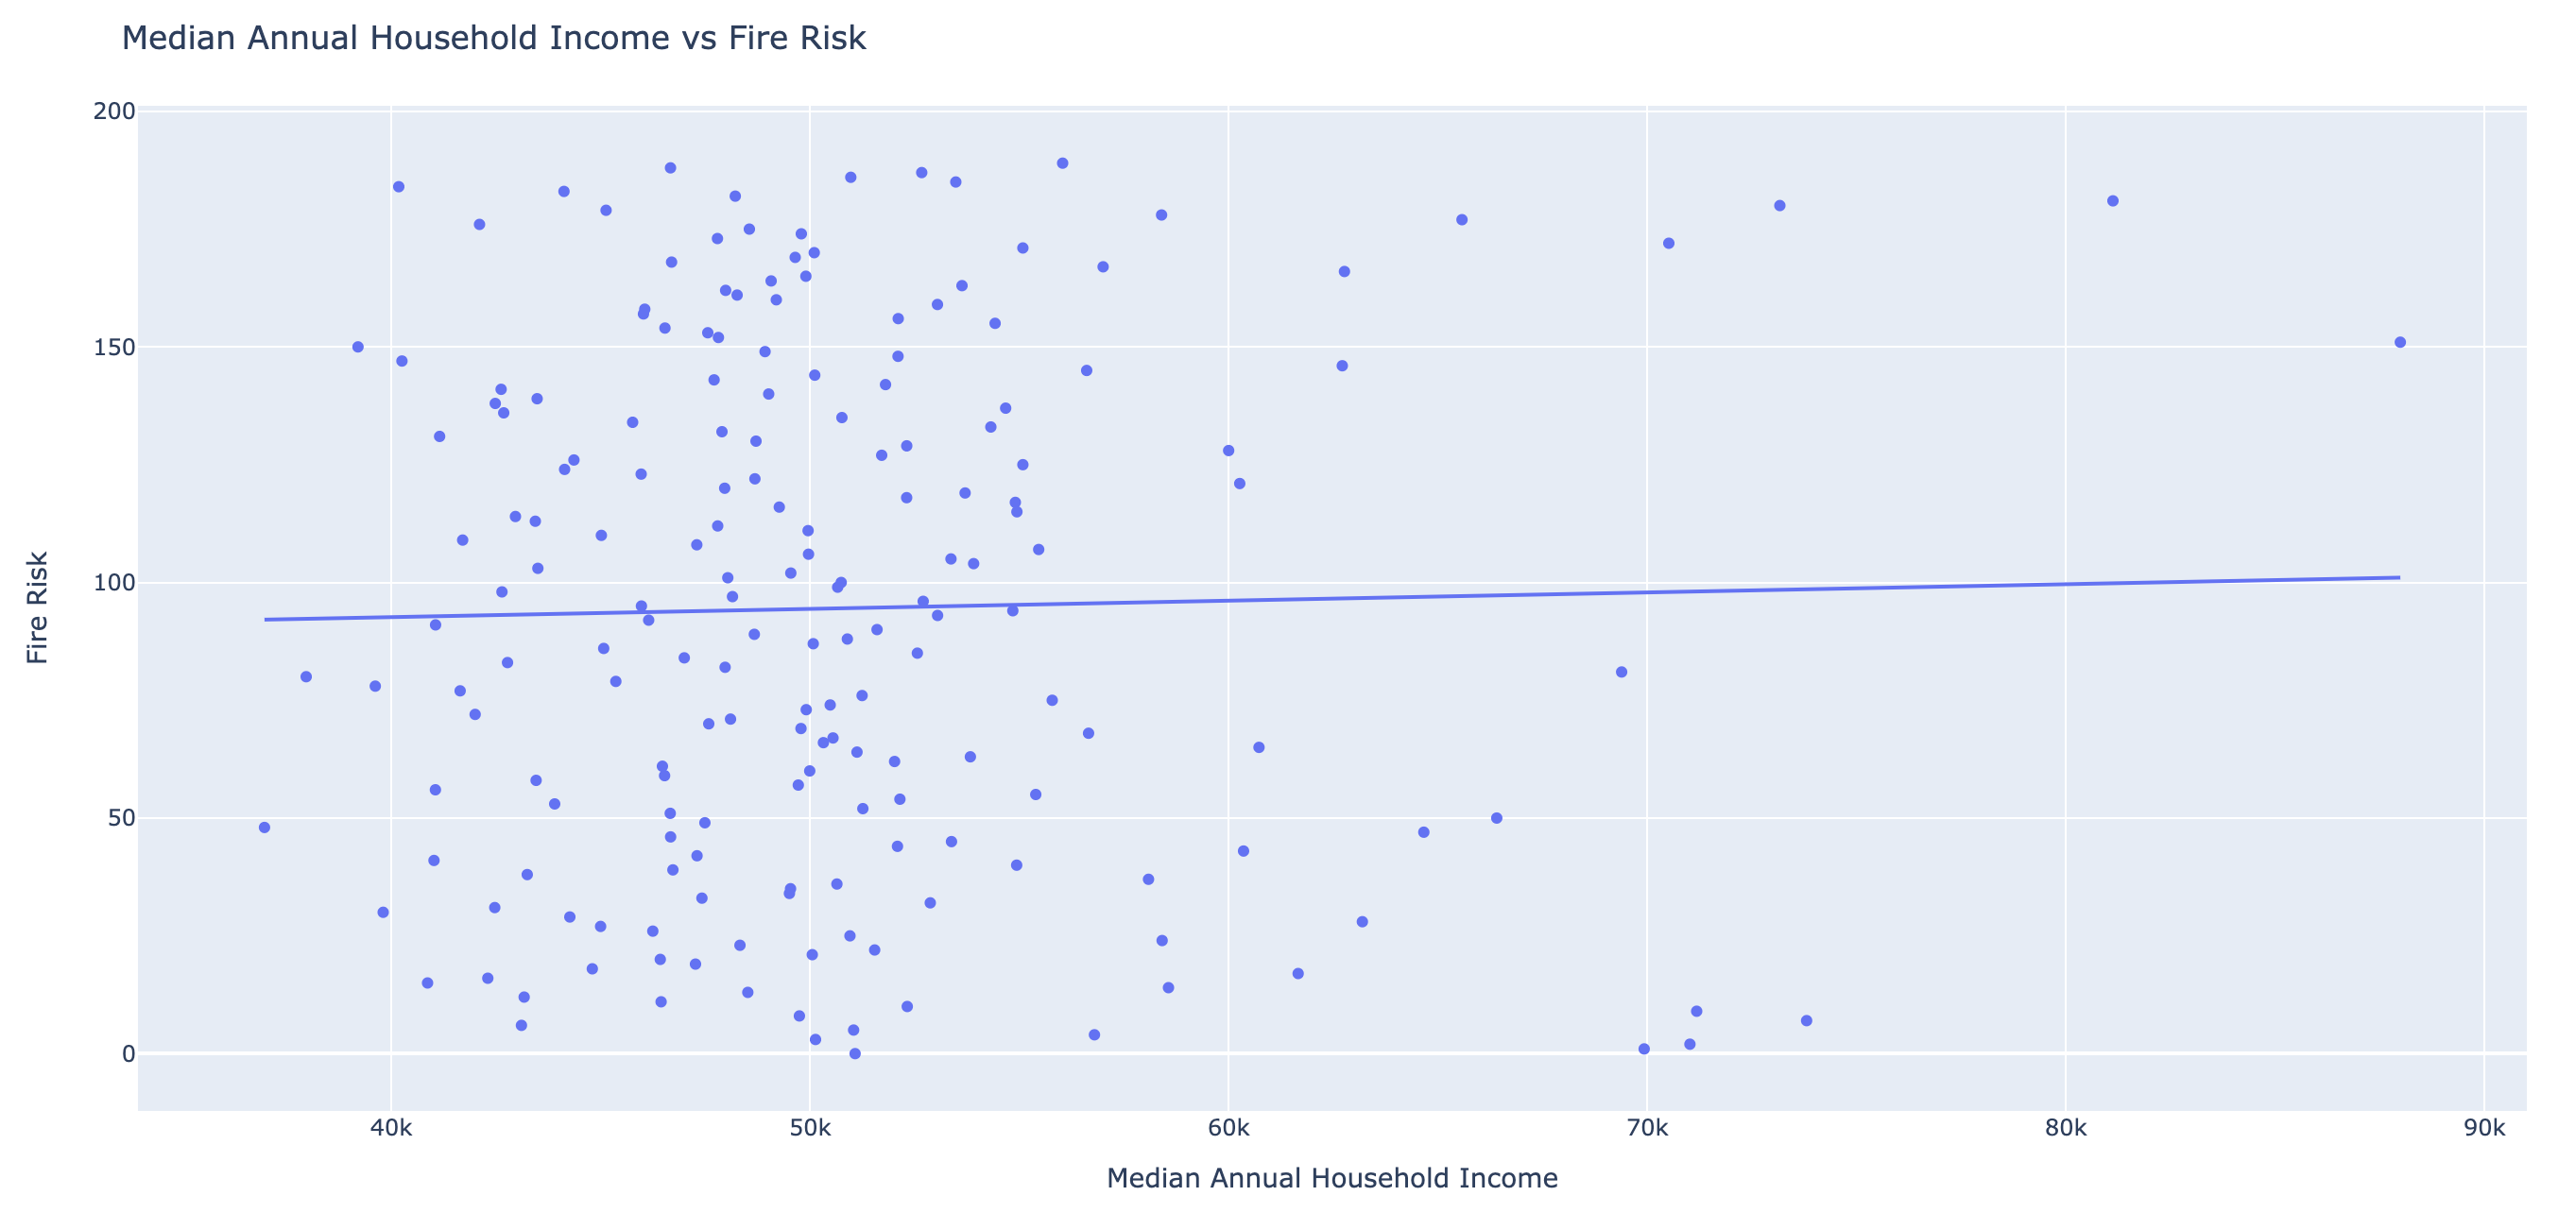

In [21]:
Image("image/median_income.png")

## Scatter plot of Average Monthly Rent vs Fire Risk
(Note: Please run below commented code for viewing interactive plots offline)

In [8]:
data3 = res3["avg_monthly_rent"]
fig1 = px.scatter(data2, data3, trendline="ols")
fig1.update_layout(
    title="Average Monthly Rent vs Fire Risk",
    xaxis_title="Average Monthly Rent",
    yaxis_title="Fire Risk",
)
#plotly.offline.plot(fig1,filename = "avg_rent.html")
fig1.show()

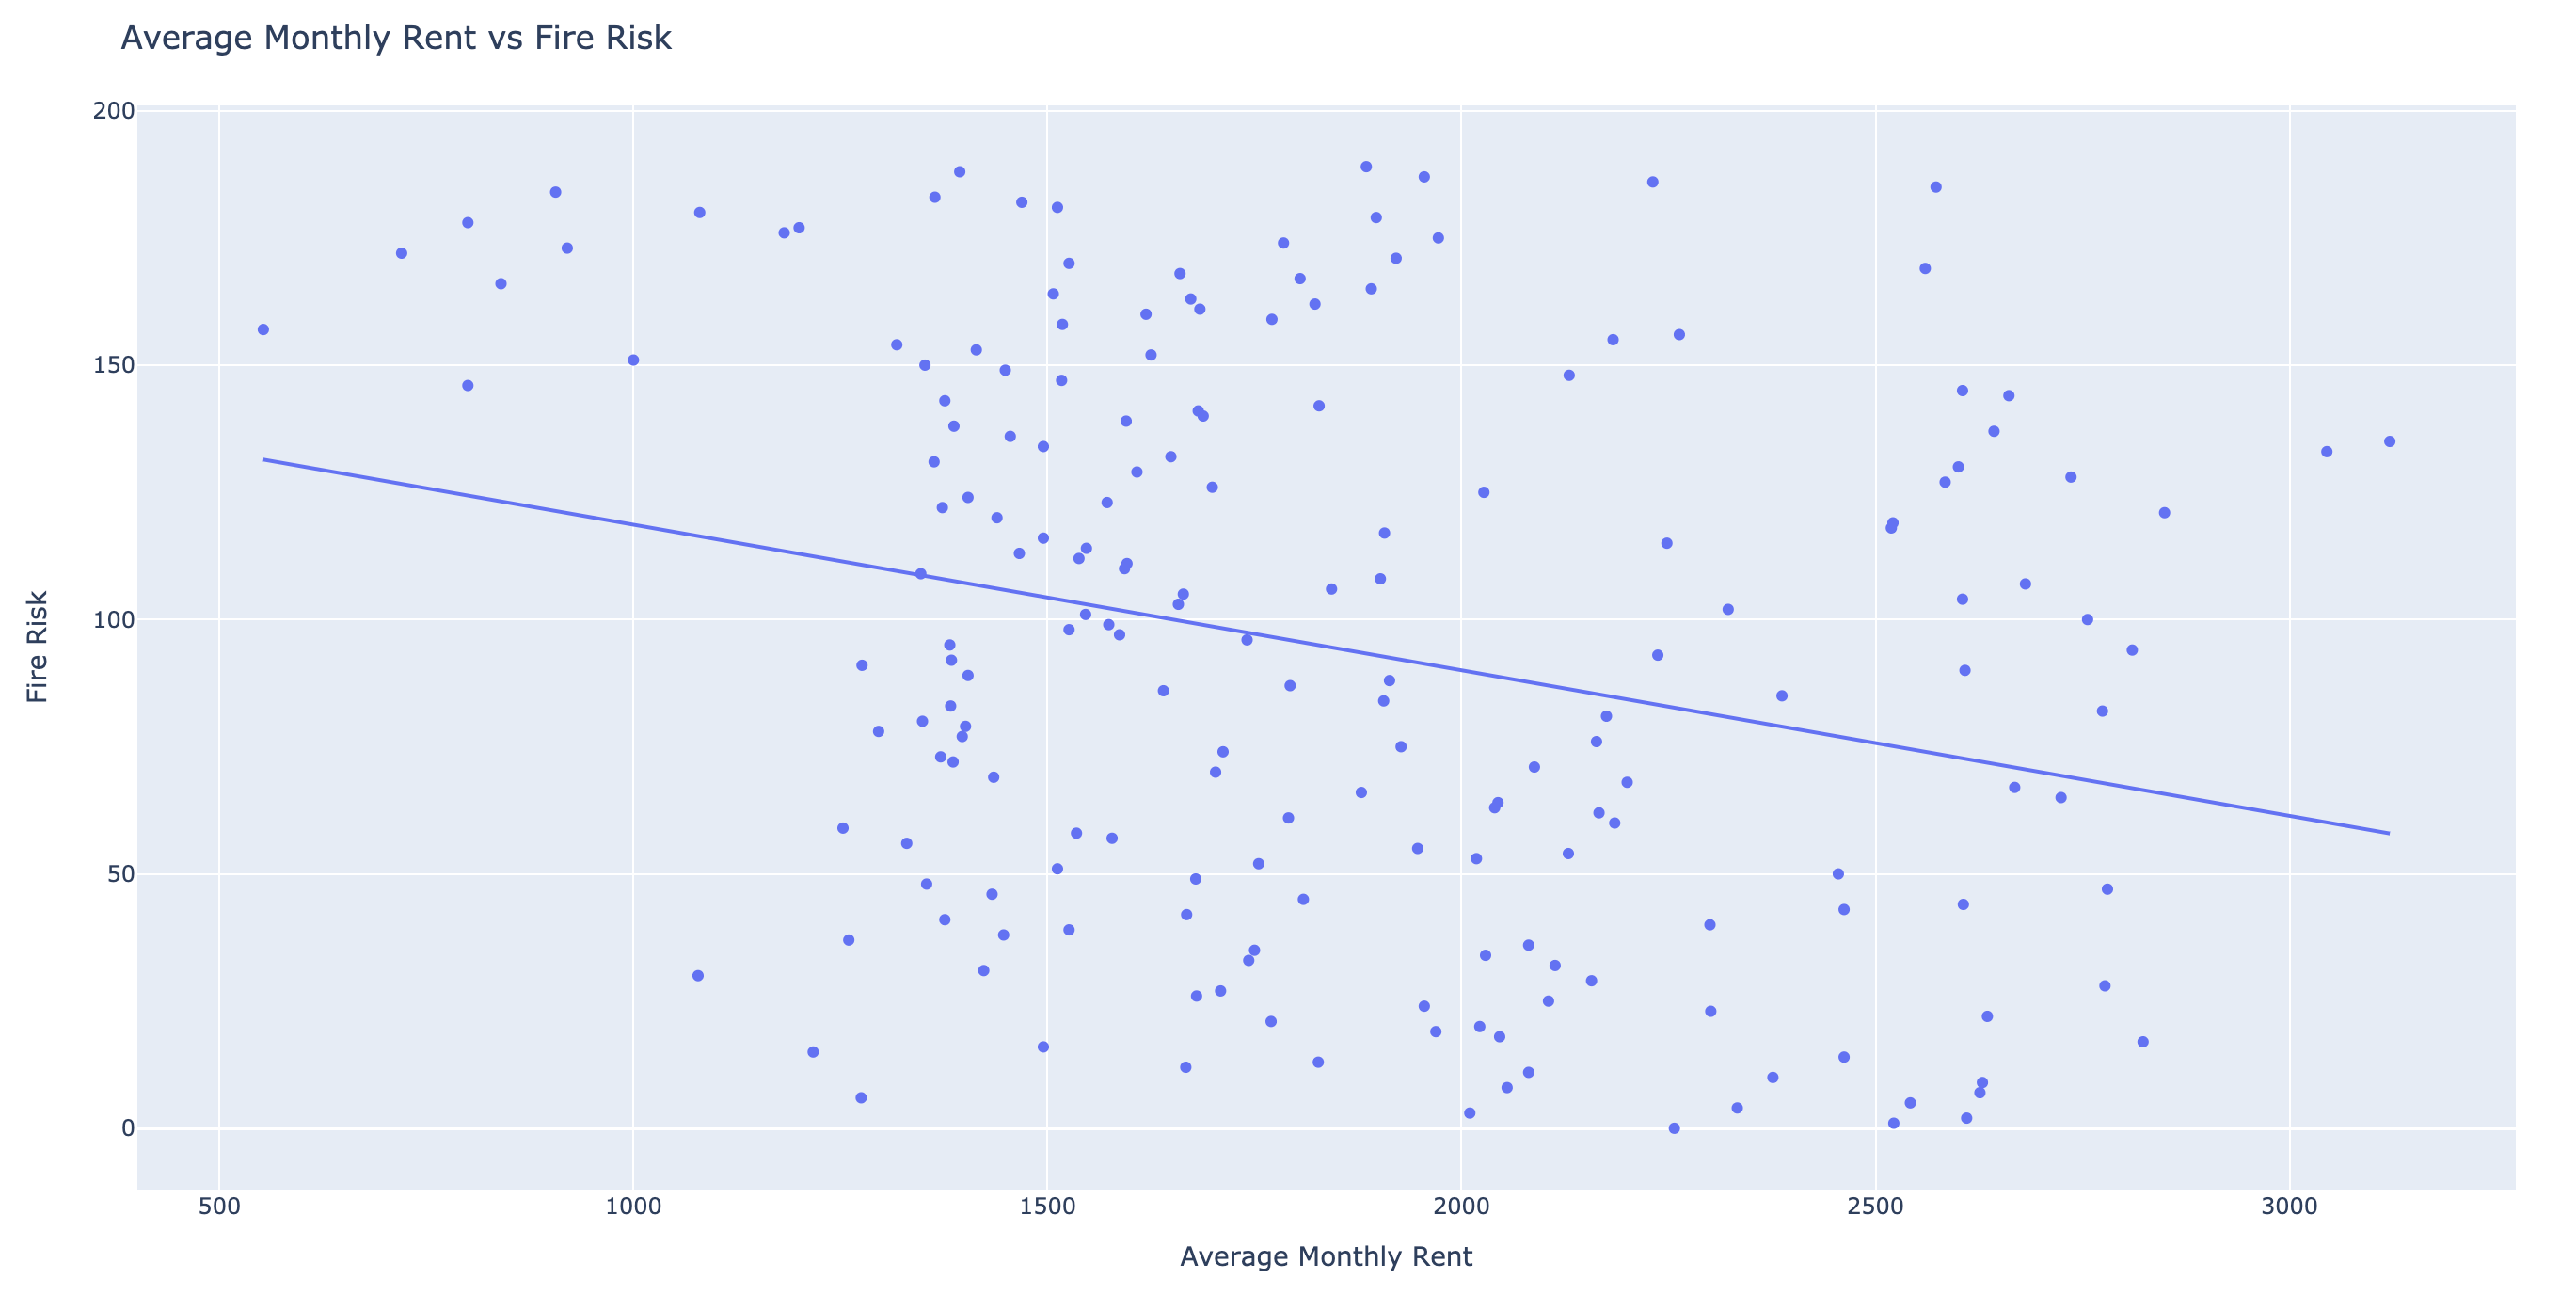

In [22]:
Image("image/avg_rent.png")

## Correlation coefficient, p-value

In [9]:
from scipy.stats import pearsonr
corr1,p_value = pearsonr(data2, data1)
print("Correlation coefficient: ",corr1)
print("P-value: ",p_value)

Correlation coefficient:  -0.02577249065704354
P-value:  0.7241157004216034


In [10]:
corr2,p_value = pearsonr(data2, data3)
print("Correlation coefficient: ", corr2)
print("P-value: ",p_value)

Correlation coefficient:  0.25777386291047205
P-value:  0.0003299270041442435


## Map Visualization for Neighbourhoods Fire Risk
(Note: Please run below code for viewing interactive map - > open "map.html" file)

In [11]:
df = gpd.GeoDataFrame.from_postgis("""SELECT * FROM risk_score;""", conn, geom_col='geom')

In [13]:
fig2 = px.choropleth(df, geojson=df.geom,locations=df.index, color="fire_risk")
fig2.update_geos(fitbounds="locations", visible=False)
plotly.offline.plot(fig2, filename = "map.html")

'map.html'

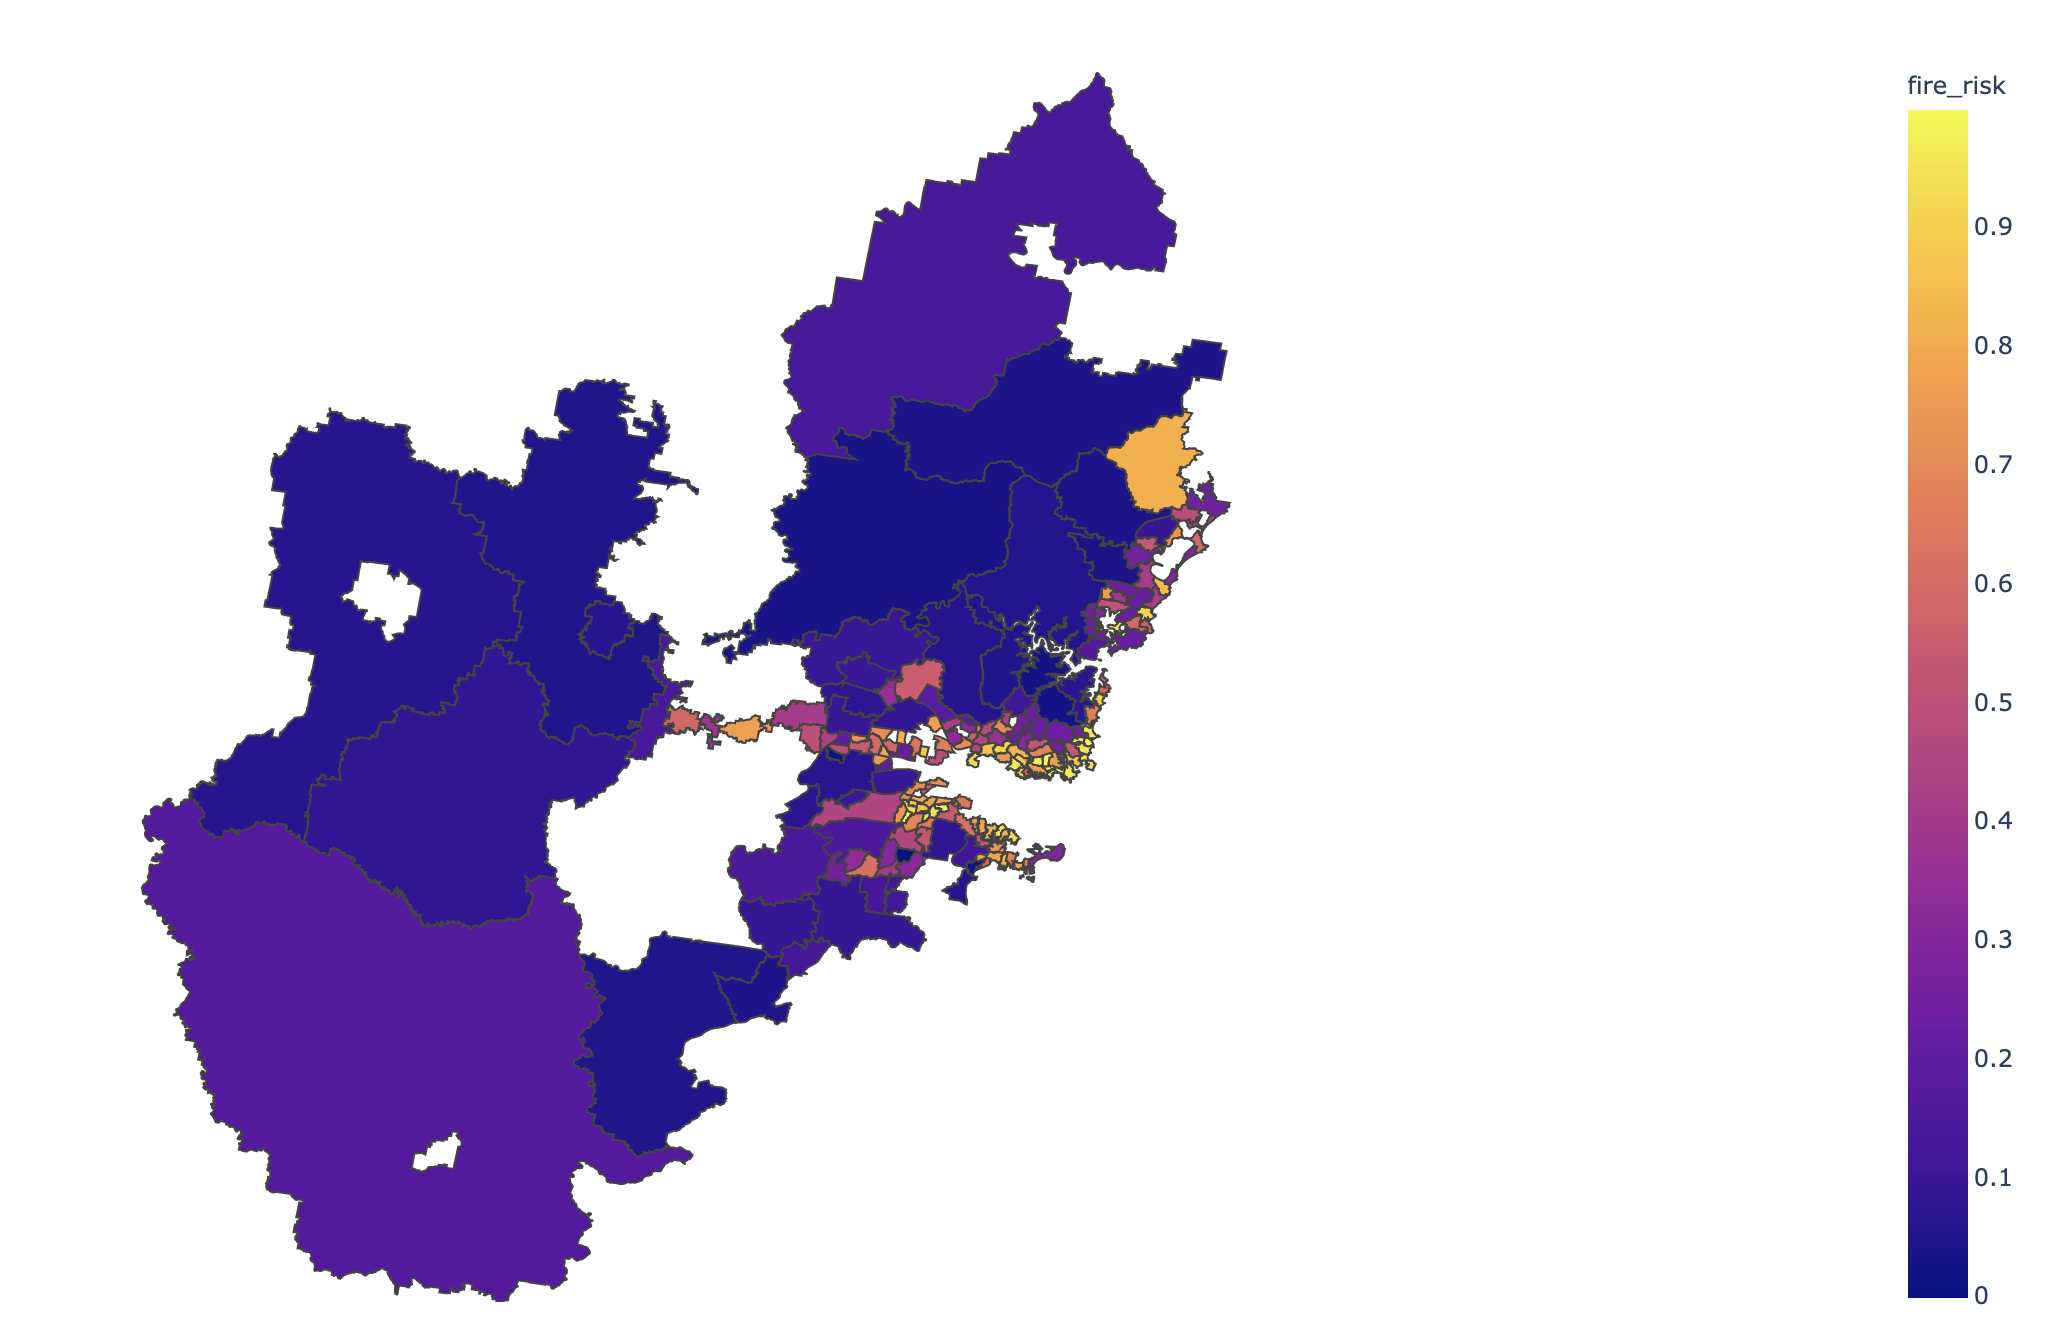

In [5]:
Image("image/map.png")

## Updating table ris_score by making it with PRIMARY KEY area_id

In [30]:
conn.execute("""ALTER TABLE risk_score
ADD CONSTRAINT PK_areaid PRIMARY KEY (area_id);""")

In [6]:
conn.close()
db.dispose()